In this post, I use a neural network with a single hidden layer to approximate a simple nonlinear function, and I will investigate how changing the number of neurons helps in learning the function representation.

<!-- TEASER_END -->

I'll start with this simple function:

$$ f(x) = \max(0, x-0.5) $$

This is a rectified linear unit (ReLU) that is shifted so the kink is at $x = 0.5$.

The first step in the network takes the input, $x$, and multiplies by the weights, $W_0$, and adds biases, $b_0$. The result of this is then passed through the activation function, $\sigma$. In the networks below, we will be taking $\sigma(x) = \max(0,x)$, a ReLU. So the output of the hidden layer will be

$$ h = \sigma(W_0 x + b_0). $$

This output is then passed to the output layer, where it is multiplied by weights, $W_1$, and summed with biases, $b_1$.

$$ y =  W_1 h + b_1 = W_1 \sigma(W_0 x + b_0) + b_1. $$

In a more general setting, the output layer also has an activation function. In this case, the activation function is just the identity, which is useful in regression settings. In the code below, this is referred to as `activation="linear"`.

In the setup considered here, $x$ has a single dimension ($1 \times 1$), so $W_0$ will be $n \times 1$ where $n$ is the number of neurons in the hidden layer, and $b_0$ will also be $n \times 1$. The result of $W_0 x + b_0$ will then be $n \times 1$. The activation function $\sigma$ is applied element-wise to the result so the dimension of the hidden layer output is $n \times 1$.

For the output layer, $W_1$ will be $1 \times n$ and $b_1$ will be a scalar. This will give a scalar output for the whole network.

Time to move on to the code. First, import all the libraries needed. I use `keras` with a `tensorflow` backend.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.initializers import Constant

Using TensorFlow backend.


Next I will create some fake data, add a little noise, and split it into training and testing sets.

In [2]:
N = 1000       # number of data points to create
scale = 0.05   # standard deviation of the noise to add

X = np.random.uniform(size=N)
Y = np.maximum(0,X-0.5) + np.random.normal(scale=scale, size=N)
X = X.reshape((N,1))
Y = Y.reshape((N,1))
x_train, y_train = X[:(N//10)*9,:], Y[:(N//10)*9,:]
x_test, y_test = X[(N//10)*9:,:], Y[(N//10)*9:,:]

Here is a plot of the data. The nonlinearity is apparent and makes it clear that a linear approximation will be poor.

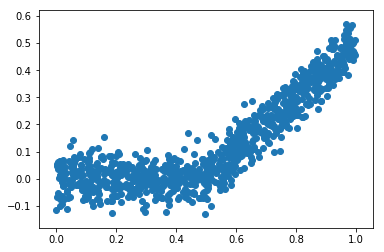

In [3]:
_ = plt.scatter(x_train, y_train)

Note we know the expected squared error, it is just the variance of the noise. This gives a lower bound on any mean squared error (MSE) from the model.

In [4]:
print("Minimum possible MSE: {:.4}".format(scale**2))

Minimum possible MSE: 0.0025


## A poor attempt

I am starting with a network with a single hidden layer. According to the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), a network with a single hidden layer and a finite number of neurons can appoximate any continuous function arbitrarily well.

Since we know the function here is a single ReLU, the network in principle only needs one neuron, so I'll start with that model.

Recall from above we had

$$ y = W_1 \sigma(W_0 x + b_0) + b_1. $$

With $\sigma = \max(0,x)$, we can recover the exact form of the function by taking $W_0 = 1$, $b_0 = -0.5$, $W_1 = 1$ and $b_1 = 0$. This gives

$$ y = 1 \sigma(1 x + (-0.5)) + 0 = \max(0, x-0.5)$$

as promised.

MSE: 0.02449
CPU times: user 1.01 s, sys: 28 ms, total: 1.04 s
Wall time: 887 ms


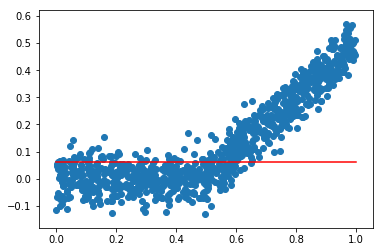

In [5]:
%%time

def create_model(num_neurons, epochs=1):
    """Create a simple network with one hidden layer
    
    num_neurons: Number of neurons in the hidden layer.
    epochs:      Number of epochs for training.
    """
    
    model = Sequential()

    # One hidden layer
    model.add(Dense(num_neurons, input_dim=1, activation="relu", kernel_initializer="normal"))
    # Output layer
    model.add(Dense(1, activation="linear", kernel_initializer="normal"))

    model.compile(loss="mse", optimizer="sgd")

    # Fit on training data, evaluate on test data
    fit = model.fit(x_train, y_train, epochs=epochs, verbose=False)
    score = model.evaluate(x_test, y_test, verbose=False)

    # See model predictions and MSE
    x_pred = np.linspace(0,1,100)
    y_pred = model.predict(x_pred)

    print("MSE: {:.4}".format(score))

    # Plot the data and predictions
    plt.scatter(x_train, y_train)
    plt.plot(x_pred, y_pred, color="red")


# Model with single neuron in the hidden layer
create_model(num_neurons=1)

The approximation is in red and does not look good. But the training only had one epoch to learn the function, how about I bump that up and give it more time to find a better approximation?

MSE: 0.01883
CPU times: user 8.99 s, sys: 1.16 s, total: 10.1 s
Wall time: 5.56 s


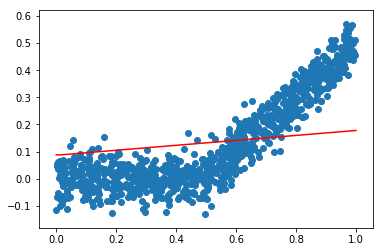

In [6]:
%%time

create_model(num_neurons=1, epochs=100)

The MSE has come down a bit but no where near the actual MSE. The approximation still looks very linear. Let's go for broke and bump the epochs up to 1000.

MSE: 0.02457
CPU times: user 1min 22s, sys: 13.2 s, total: 1min 36s
Wall time: 48.2 s


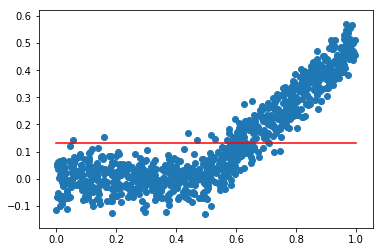

In [7]:
%%time

create_model(num_neurons=1, epochs=1000)

So we have upped the training time by a few orders of magnitude and we have almost nothing to show for it. So what is going on?

## Cheater fix: adjust the initializers

One thing that can be done is give the network a little (or big) hint about what the underlying function is. In general, the advice for initizling the network is to set weights to random numbers that are close to zero and start the biases at 0. This is how the network above was constructed.

Using the `kernel_initizlizer`, `bias_initializer` and the `keras` class `Constant`, we can essentially start the network closer to a good solution.

MSE: 0.002504


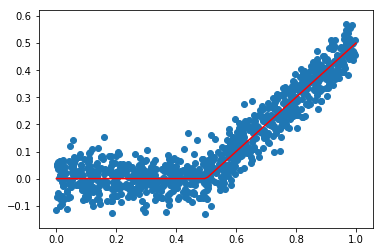

In [8]:
model = Sequential()

# One hidden layer, 1 hidden unit
model.add(Dense(1, input_dim=1, activation="relu", kernel_initializer=Constant(1), bias_initializer=Constant(-0.5)))
# Output layer
model.add(Dense(1, activation="linear", kernel_initializer=Constant(1)))

model.compile(loss="mse", optimizer="sgd")

fit = model.fit(x_train, y_train, epochs=1, verbose=False)
score = model.evaluate(x_test, y_test, verbose=False)

x_pred = np.linspace(0,1,100)
y_pred = model.predict(x_pred)

print("MSE: {:.4}".format(score))

plt.scatter(x_train, y_train)
_ = plt.plot(x_pred, y_pred, color="red")

This looks great and might seem like a great idea until it becomes clear that this only works when a good guess for the starting values is known. If that were the case in general, a neural network might not be needed in the first place.

## Better fix: increase the number of neurons

In some sense, the first model above was having too hard a time learning the parameters. To help it along, more neurons can be added to the hidden layer. Below I run the model with 100 neurons and 1,000 neurons with different epochs.

MSE: 0.006798
CPU times: user 8.79 s, sys: 1.28 s, total: 10.1 s
Wall time: 5.52 s


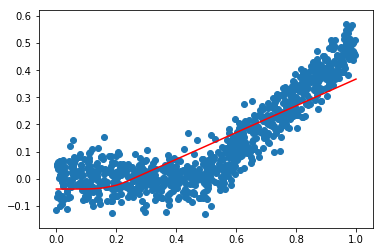

In [9]:
%%time

create_model(num_neurons=100, epochs=100)

MSE: 0.002511
CPU times: user 42.6 s, sys: 6.22 s, total: 48.8 s
Wall time: 24.8 s


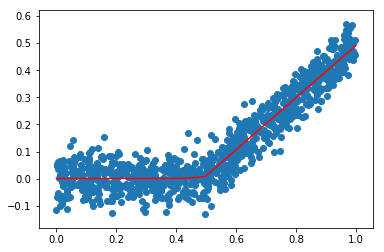

In [10]:
%%time

create_model(num_neurons=100, epochs=500)

MSE: 0.003966
CPU times: user 11.7 s, sys: 1.24 s, total: 12.9 s
Wall time: 7.23 s


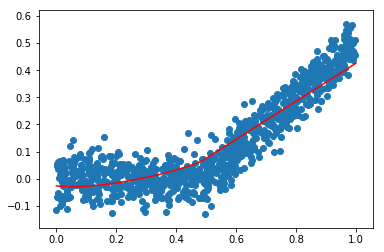

In [11]:
%%time

create_model(num_neurons=1000, epochs=100)

MSE: 0.002799
CPU times: user 22.3 s, sys: 2.63 s, total: 24.9 s
Wall time: 13.3 s


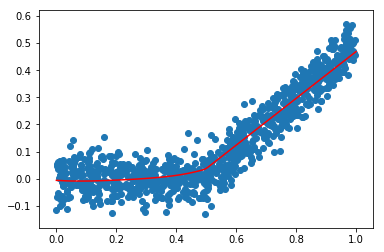

In [12]:
%%time

create_model(num_neurons=1000, epochs=200)

This is starting to look decent and the MSE is approacing the actual error.

## Conclusion

To summarize, a network will have a hard time learning if it is not flexible enough. Adding more neurons to a layer helps with flexibility. This is sometimes referred to as the width, i.e. adding more neurons makes the network wider.

In the next post, we will look at adding more hidden layers. This is referred to as making the network deeper.